### Importing libraries

In [69]:
# pip install tensorflow
# check out https://www.tensorflow.org/tutorials/images/cnn
# can run and compare results in colab

In [1]:
import os
import pandas as pd
import numpy as np

# import required libaries to process images
import PIL
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline 
 
#using Keras
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, preprocessing
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential

Using TensorFlow backend.


### Importing and examining the images

In [246]:
def resize_image(img):
    width, height = img.size
    ratio = width/height
    new_height = 100
    new_width = int(new_height*ratio)
    img = img.resize((new_width, new_height))
    return img

In [13]:
# follow this on zero padding vs resizing and how it effects accuracy 
# mabye something we talk to Jiaqi about
def pad_images(images, width_max, length_max): 
    padded_images = [] 
    c = 0 
    for image in images: 
        wpad1 = (width_max - image.shape[0])/2
        lpad1 = (length_max - image.shape[1])/2

        if lpad1%1 > 0: 
            lpad1 = int(lpad1)
            lpad2 = int(lpad1)+1
        else: 
            lpad1 = int(lpad1)
            lpad2 = int(lpad1)

        if wpad1%1 > 0: 
            wpad1 = int(wpad1)
            wpad2 = int(wpad1)+1
        else: 
            wpad1 = int(wpad1)
            wpad2 = int(wpad1)
        try:
            padded_images.append(np.pad(image, pad_width=[(wpad1 , wpad2),(lpad1, lpad2),(0, 0)], mode='constant'))
        except: 
            print("at {}".format(c))
        c = c + 1
    return padded_images

In [12]:
#crop images to center based on full dataset mean_size
def crop_images(images, width_mean, length_mean):
    train_padded_c = []
    for image in images: 
        
        left = int((image.shape[0] - int(width_mean))/2)
        top = int((image.shape[1] - int(length_mean))/2)
        right = int((image.shape[0] + int(width_mean))/2)
        bottom = int((image.shape[1] + int(length_mean))/2)

        train_padded_c.append(image[left:right, top:bottom])
    return train_padded_c

In [11]:
def get_image_stats(image_arrays):
    widths = [array.shape[0] for array in image_arrays]
    lengths = [array.shape[1] for array in image_arrays]
    width_mean = np.mean(widths)
    length_mean = np.mean(lengths)
    width_max = np.max(widths)
    length_max = np.max(lengths)
    return length_mean, length_max, width_max, width_mean

In [250]:
def load_images(img_dir, type, height):
    ''' Type as int 0 no_fire 1 fire
        desired height of image as int 
        img_dir as str folder name where images stored'''

    #get list of images 
    dir = os.getcwd()
    images = os.listdir('{}/assets/{}'.format(dir, img_dir))
    image_file = [file for file in images if '.DS_Store' not in file]
    image_arrays = [np.asarray(resize_image(Image.open('{}/assets/{}/{}'.format(dir,img_dir, image)))) for image in image_file]
    
    #get_labels
    label_arrays = []
    for array in image_arrays:
        label_arrays.append([type])
    image_labels = label_arrays

    data = list(zip(image_arrays, image_labels))

    return data


In [251]:
wildfire_train_set_Unprocessed = load_images('wildfire_train_set - Unprocessed', 1, 100)
wildfire_test_set = load_images('wildfire_test_set', 1, 100)
mountain_test_set = load_images('mountain_test_set', 0, 100)

In [7]:
mountain_test_set = data

In [9]:
data = []
data.extend(wildfire_train_set_Unprocessed)
data.extend(wildfire_test_set)
data.extend(mountain_test_set)

In [14]:
images, labels = zip(*data)

length_mean, length_max, width_max, width_mean = get_image_stats(images)

#crop and pad images
images_cropped = pad_images(images, width_max, length_max)
images_final = crop_images(images_cropped, width_mean, length_mean)

#convert all imagees to RGB some are ARGB
images_final = [np.array(Image.fromarray(image).convert('RGB')) for image in images_final]

data = list(zip(images_final, labels))

In [19]:
def test_train_split(data):
    # randomize the images
    import random 
    random.seed(42)
    random.shuffle(data)

    #split into train, test, dev
    data_len = len(data)
    train, dev, test = np.split(data, [int(data_len*.8),int(data_len*.9)])
    train_images, train_labels = zip(*train)
    dev_images, dev_labels = zip(*dev)
    test_images, test_labels = zip(*test)
    
    return train_images, train_labels, dev_images, dev_labels, test_images, test_labels
train_images, train_labels, dev_images, dev_labels, test_images, test_labels = test_train_split(data)

In [20]:
#normalize the images
train_images, dev_images, test_images = np.array(train_images) / 255.0, \
                                        np.array(dev_images) / 255.0, \
                                        np.array(test_images) / 255.0,

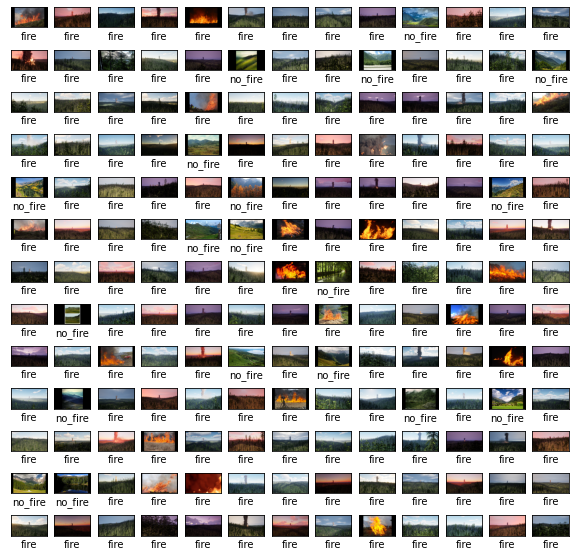

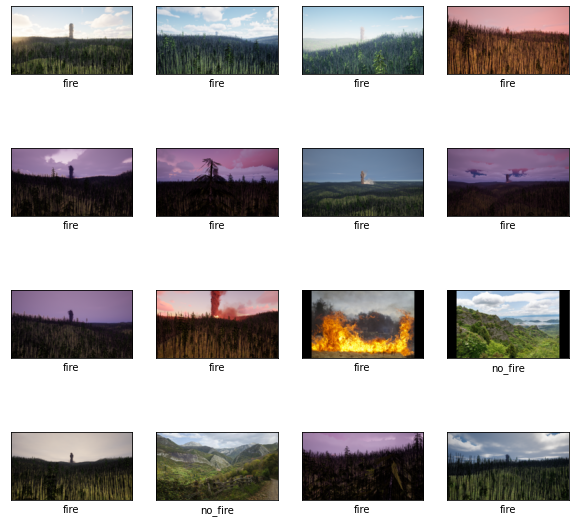

In [38]:
#testing label application
def plot_images(images, labels):
    import math

    p_size = math.floor(math.sqrt(len(images)))

    class_names = ['no_fire','fire']
    plt.figure(figsize=(10,10))
    for i in range(p_size**2):
        plt.subplot(p_size,p_size,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(class_names[int(labels[i][0])])
    
plot_images(train_images, train_labels)
plot_images(test_images, test_labels)

In [190]:
train_images.shape

TensorShape([100, 163, 3])

In [252]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [188]:
train_images = tf.convert_to_tensor(train_images, dtype=tf.float32)
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.float32)
test_images = tf.convert_to_tensor(test_images, dtype=tf.float32)
test_labels = tf.convert_to_tensor(test_labels, dtype=tf.float32)

In [189]:
#checking out the shape for standardization
def shaping (all_images):
    width_means = []
    length_means = []
    for array in all_images:

    #     print(array.shape)

        #width to length ratio
    #     print(array.shape[0]/array.shape[1])

        #width & length means
        width_means.append(array.shape[0])
        length_means.append(array.shape[1])

    width_mean = np.mean(width_means)
    length_mean = np.mean(length_means)

    print(' ')
    print('----------------')
    print('width mean')
    print(width_mean)
    print('----------------')
    print('length mean')
    print(length_mean)
    return None

In [191]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 163, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [192]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 161, 32)       896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 80, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 78, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 39, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 37, 64)        36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
_________________________________________________________________


In [193]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [194]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 161, 32)       896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 80, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 78, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 39, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 37, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 49728)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

In [195]:
epochs=10

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=epochs, 
                    validation_data=(test_images, test_labels))

Train on 311 samples, validate on 39 samples
Epoch 1/10
311/311 [==============================] - 22s 70ms/sample - loss: 0.5888 - accuracy: 0.8392 - val_loss: 0.2662 - val_accuracy: 0.9231
Epoch 2/10
311/311 [==============================] - 11s 35ms/sample - loss: 0.1384 - accuracy: 0.9518 - val_loss: 0.1131 - val_accuracy: 0.9744
Epoch 3/10
311/311 [==============================] - 6s 19ms/sample - loss: 0.0588 - accuracy: 0.9775 - val_loss: 0.0688 - val_accuracy: 0.9744
Epoch 4/10
311/311 [==============================] - 6s 18ms/sample - loss: 0.0115 - accuracy: 1.0000 - val_loss: 0.1405 - val_accuracy: 0.9744
Epoch 5/10
311/311 [==============================] - 6s 19ms/sample - loss: 0.0149 - accuracy: 0.9904 - val_loss: 0.2220 - val_accuracy: 0.9744
Epoch 6/10
311/311 [==============================] - 6s 18ms/sample - loss: 0.0199 - accuracy: 0.9968 - val_loss: 0.1438 - val_accuracy: 0.9744
Epoch 7/10
311/311 [==============================] - 6s 19ms/sample - loss: 0.0049

39/1 - 0s - loss: 0.0579 - accuracy: 0.9744


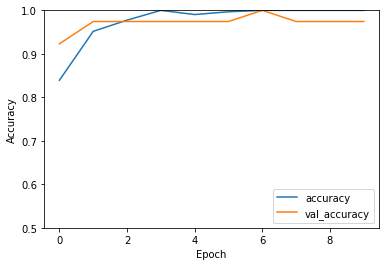

In [196]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

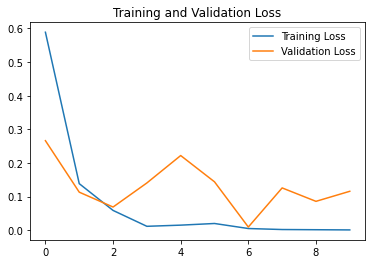

In [197]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Data augmentation

In [206]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(100, 163, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

AttributeError: module 'tensorflow_core.keras.layers' has no attribute 'RandomFlip'

In [198]:
plt.figure(figsize=(10, 10))
# for images in train_images:
for i in range(9):
    augmented_images = data_augmentation(train_images[i])
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images)#.numpy().astype("uint8"))
    plt.axis("off")

NameError: name 'data_augmentation' is not defined

<Figure size 720x720 with 0 Axes>

In [41]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(5)
])

In [42]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [43]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 952, 1328, 3)      0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 952, 1328, 3)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 952, 1328, 16)     448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 476, 664, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 476, 664, 32)      4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 238, 332, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 238, 332, 64)     

In [45]:
epochs = 10
history = model.fit(
  train_images,train_labels,
  validation_data=(test_images, test_labels),
  epochs=epochs
)

Epoch 1/10
2/2 [==============================] - 78s 22s/step - loss: 1.4707 - accuracy: 0.2750 - val_loss: 4.7912 - val_accuracy: 0.2000
Epoch 2/10
2/2 [==============================] - 37s 19s/step - loss: 2.0776 - accuracy: 0.5750 - val_loss: 0.6110 - val_accuracy: 0.8000
Epoch 3/10
2/2 [==============================] - 36s 19s/step - loss: 0.8112 - accuracy: 0.4250 - val_loss: 0.6410 - val_accuracy: 0.8000
Epoch 4/10
2/2 [==============================] - 37s 19s/step - loss: 0.8880 - accuracy: 0.4250 - val_loss: 0.5386 - val_accuracy: 0.8000
Epoch 5/10
2/2 [==============================] - 37s 20s/step - loss: 0.8484 - accuracy: 0.4250 - val_loss: 0.7381 - val_accuracy: 0.4000
Epoch 6/10
2/2 [==============================] - 36s 19s/step - loss: 0.7089 - accuracy: 0.6500 - val_loss: 1.0443 - val_accuracy: 0.2000
Epoch 7/10
2/2 [==============================] - 36s 19s/step - loss: 0.7328 - accuracy: 0.5750 - val_loss: 1.0665 - val_accuracy: 0.2000
Epoch 8/10
2/2 [===========